In [1]:
import pickle # 객체 입출력을 위한 라이브러리
from sklearn.model_selection import train_test_split # 훈련 데이터, 테스트 데이터 분리
from sklearn.preprocessing import StandardScaler # 정규화
from sklearn.ensemble import RandomForestClassifier # 랜덤포레스트 분류 알고리즘
import pandas as pd

# 모델 평가를 위한 metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
binary_concat=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/open_binary.csv")
binary_concat.head()

,N_in_packets,N_out_packets,in_first_thirty,out_first_thirty,out_fraction,in_fraction,out_std,in_std,out_mean,in_mean,N_packets,time_fraction,sum_N,y
0,1300,121,21,9,0.085151,0.914849,398.486335,515.483953,705.106154,774.322314,1421,140.138067,2842,1
1,438,80,22,8,0.154440,0.845560,150.591146,139.231951,265.406393,227.162500,518,50.984252,1036,1
2,1240,118,23,7,0.086892,0.913108,381.878642,472.735508,669.259677,787.110169,1358,122.232223,2716,1
3,1324,122,21,9,0.084371,0.915629,406.205288,513.916038,714.503021,821.139344,1446,108.233533,2892,1
4,1291,115,22,8,0.081792,0.918208,395.028889,503.993490,695.740511,790.608696,1406,132.142857,2812,1


In [4]:
# 정답값 아닌 애들 분리
X= binary_concat.drop('y', axis=1)
# 목표변수 분리(정답값. 어느 클래스 label에 해당하는지 해당 열)
y = binary_concat['y']

In [5]:
# train, test 데이터 분리

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, random_state = 1)

# 데이터 스케일링(normalize data)

 #표준 스케일러(평균 0, 분산 1)
#scaler = StandardScaler()
#X_train= scaler.fit_transform(X_train)
#X_test= scaler.fit_transform(X_test)

In [6]:
rf_clf2 = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=1,
                                 min_samples_split=2, random_state=0)
rf_clf2.fit(X_train , y_train)
pred = rf_clf2.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

예측 정확도: 0.8416


In [7]:
# GridSearch로 최적의 하이퍼 파라미터 튜닝

from sklearn.model_selection import GridSearchCV

params = {#'n_estimators' : [100, 150, 200],
          'max_depth' : [30, 50, 70],
          'min_samples_leaf' : [1,5,10],
          'min_samples_split' : [ 2, 5, 8],
          #'criterion' : ['gini', 'entropy']
          }


# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf_bi = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv_bi = GridSearchCV(rf_clf_bi , param_grid=params , cv=3, n_jobs=-1 )
grid_cv_bi.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv_bi.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv_bi.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
최고 예측 정확도: 0.8359


In [8]:
# 위의 결과로 나온 최적 하이퍼 파라미터로 테스트 세트 데이터에서 예측 성능을 측정

y_pred = grid_cv_bi.predict(X_test)
print('예측 정확도: {:.4f}'.format(grid_cv_bi.best_score_))
print('test 정확도: {:.4f}'.format(accuracy_score(y_test,y_pred)))
print('오차 행렬')
print(confusion_matrix( y_test, y_pred))
print(classification_report(y_test, y_pred))

예측 정확도: 0.8359
test 정확도: 0.8440
오차 행렬
[[2114  853]
 [ 504 5229]]
              precision    recall  f1-score   support

          -1       0.81      0.71      0.76      2967
           1       0.86      0.91      0.89      5733

    accuracy                           0.84      8700
   macro avg       0.83      0.81      0.82      8700
weighted avg       0.84      0.84      0.84      8700



In [9]:
# feature names 뽑기(header 제외)
a=binary_concat.drop(['y'], axis=1)
column_headers=list(a.columns.values)

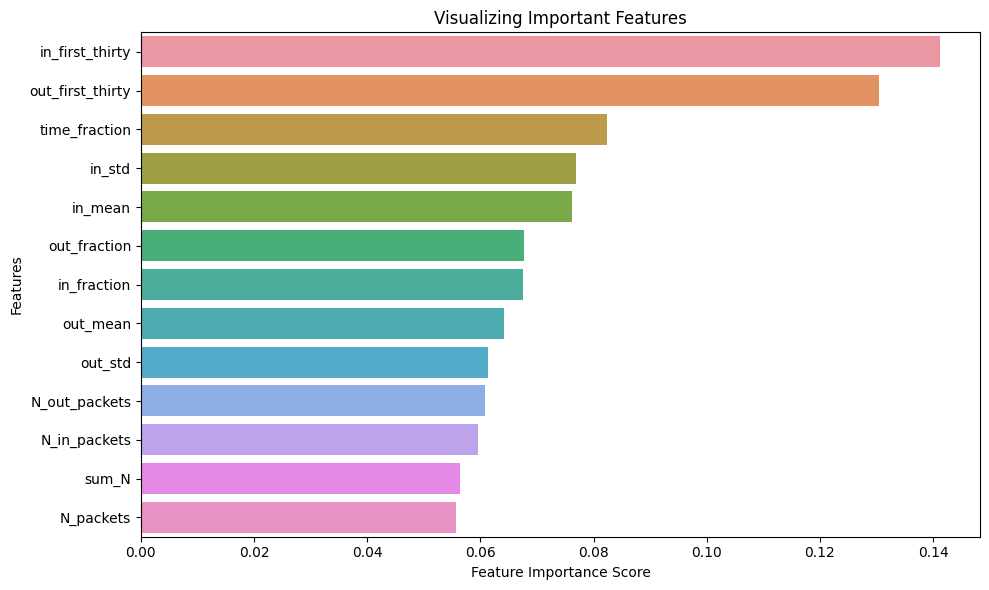

In [10]:
# 5. Report the feature rankings with importance scores using the bar plot using barplot provided by seaborn library.

import seaborn as sns
import matplotlib.pyplot as plt

best_params=grid_cv_bi.best_params_
best_rf_clf = RandomForestClassifier(**best_params)
best_rf_clf.fit(X_train, y_train)
#accuracy = best_rf_clf.score(X_test, y_test)
#print("모델 재훈련 테스트 정확도:", accuracy)

feature_imp = pd.Series(best_rf_clf.feature_importances_, index=column_headers).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()